In [1]:
import os, sys
import logging
import numpy as np
import torch
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from model import PatchModel, PatchGroupingNet, ConvModel, DifferentiablePatchGrouping
from dataset_builder import build_dataset
from puzzle_utils import batch_tch_divide_image, reconstruct_image_from_groups, get_groups, model_based_grouping
import matplotlib.pyplot as plt
from utils import gumbel_sinkhorn_ops, metric

/home/adwai/anaconda3/envs/gnr1/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class CFG:
    def __init__(self):
        self.root = "./data" 
        self.out_dir = "./log"
        # optimizer option
        self.epochs = 4 
        self.lr = 1e-3 
        self.batch_size=1 
        self.num_workers=8 
        # dataset option
        self.dataset = "MNIST" 
        self.pieces = 8 
        self.groups = 4 
        self.image_size = 32
        # model parameter option
        self.hid_c = 64 
        self.stride = 1 
        self.kernel_size = 5 
        # Gumbel sinkhorn option
        self.tau = 1.0
        self.n_sink_iter = 20 
        self.n_samples = 5 
        # misc option
        self.display = 50 
        self.eval_only = False 

cfg = CFG()

In [3]:
if not os.path.exists(cfg.out_dir):
    os.makedirs(cfg.out_dir, exist_ok=True)  # Use makedirs with exist_ok flag for better error handling

# logger setup
logging.basicConfig(
    filename=os.path.join(cfg.out_dir, "console.log"),
)
plain_formatter = logging.Formatter(
    "[%(asctime)s] %(name)s %(levelname)s: %(message)s", datefmt="%m/%d %H:%M:%S"
)
logger = logging.getLogger("JigsawPuzzle")
logger.setLevel(logging.DEBUG)
ch = logging.StreamHandler(stream=sys.stdout)
ch.setLevel(logging.DEBUG)
formatter = plain_formatter
ch.setFormatter(formatter)
logger.addHandler(ch)

if not cfg.eval_only:
    pass
    # train_results = train(cfg)

In [4]:
logger = logging.getLogger("JigsawPuzzle")

device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda":
    torch.backends.cudnn.benchmark = True
in_c = 1 if cfg.dataset == "MNIST" else 3

model_patch = ConvModel(in_c, cfg.pieces // cfg.groups, cfg.image_size // cfg.groups, cfg.hid_c, cfg.stride, cfg.kernel_size)
model_group = ConvModel(in_c, cfg.groups, cfg.image_size, cfg.hid_c, cfg.stride, cfg.kernel_size)
# model_grouping = PatchGroupingNet(patch_size=cfg.image_size//cfg.pieces, num_groups=cfg.groups**2)
model_grouping = DifferentiablePatchGrouping(num_groups=cfg.groups**2)
model_patch.load_state_dict(torch.load(os.path.join(cfg.out_dir, "model_patch.pth")))
model_group.load_state_dict(torch.load(os.path.join(cfg.out_dir, "model_group.pth")))
# model_grouping.load_state_dict(torch.load(os.path.join(cfg.out_dir, "model_grouping.pth")))
model_patch = model_patch.to(device).eval()
model_group = model_group.to(device).eval()
model_grouping = model_grouping.to(device).eval()

# Load data
eval_data = build_dataset(cfg, split="test")
loader = DataLoader(eval_data, cfg.batch_size, shuffle=False, num_workers=cfg.num_workers, drop_last=False)

In [23]:
inputs = None
pieces = None
random_pieces = None
for i, data in enumerate(loader):
    if i <= 1:
        continue
    inputs, _ = data
    if cfg.image_size > 28:
        inputs = F.interpolate(inputs, size=(cfg.image_size, cfg.image_size), mode='bilinear', align_corners=False)
    pieces, random_pieces, perm_index = batch_tch_divide_image(inputs, cfg.pieces)
    pieces, random_pieces = pieces.to(device), random_pieces.to(device)
    break

print(inputs.shape)
image = inputs[0, 0, :, :]
print(image.shape)

torch.Size([1, 1, 32, 32])
torch.Size([32, 32])


In [24]:
def tensor_to_image(tensor):
    if isinstance(tensor, torch.Tensor):
        tensor = tensor.detach().cpu().numpy()

    if tensor.ndim != 2:
        raise ValueError("Each tensor must be 2D (grayscale).")

    # Normalize to [0, 1]
    tensor_min = np.min(tensor)
    tensor_max = np.max(tensor)
    if tensor_max > tensor_min:
        image = (tensor - tensor_min) / (tensor_max - tensor_min)
    else:
        image = np.zeros_like(tensor)

    return image


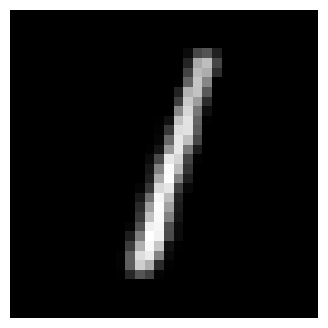

In [25]:
image = tensor_to_image(image)
plt.figure(figsize=(4, 4))
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()

In [26]:
print(pieces.shape)

torch.Size([1, 64, 1, 4, 4])


In [27]:
def plot_tensor_grid(img_tensor, cmap='gray', ncols=cfg.pieces, save_path=None, show=True, size=0.5):
    tensor_list = []
    for i in range(img_tensor.shape[0]):
        tensor_list.append(img_tensor[i])
    n = len(tensor_list)
    nrows = int(np.ceil(n / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * size, nrows * size))
    axes = np.array(axes).reshape(nrows, ncols)

    for idx, tensor in enumerate(tensor_list):
        row = idx // ncols
        col = idx % ncols
        img = tensor_to_image(tensor)
        axes[row, col].imshow(img, cmap=cmap)
        axes[row, col].axis('off')

    # Hide any unused subplots
    for i in range(n, nrows * ncols):
        row = i // ncols
        col = i % ncols
        axes[row, col].axis('off')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    if show:
        plt.show()

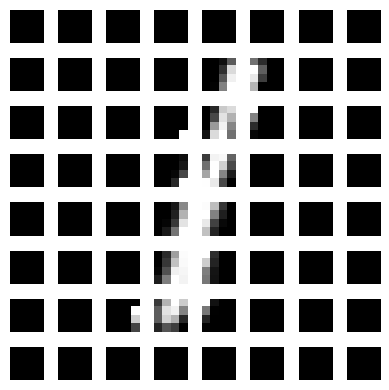

In [28]:
plot_tensor_grid(pieces[0, :, 0, :, :], size=0.5)

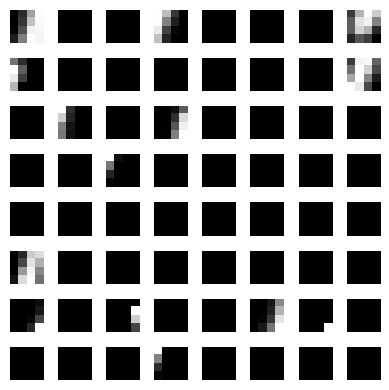

In [29]:
plot_tensor_grid(random_pieces[0, :, 0, :])

In [30]:
def stack_patches_in_group(x):
    B, G, N, C, H, W = x.shape
    assert N == 4, "This function assumes stacking 4 patches (2x2 grid)"

    # Reshape to (B*G, 4, C, H, W)
    x = x.view(B * G, 4, C, H, W)

    # Arrange the 4 patches into a 2x2 grid
    top = torch.cat([x[:, 0], x[:, 1]], dim=3)  # (B*G, C, H, 2*W)
    bottom = torch.cat([x[:, 2], x[:, 3]], dim=3)
    stacked = torch.cat([top, bottom], dim=2)  # (B*G, C, 2*H, 2*W)

    return stacked.view(B, G, C, 2 * H, 2 * W)

def unstack_patches_in_group(x):
    B, G, C, H, W = x.shape
    assert H % 2 == 0 and W % 2 == 0, "H and W must be even"

    h, w = H // 2, W // 2
    x = x.view(B * G, C, H, W)

    # Extract the 4 patches
    patch_0 = x[:, :, :h, :w]  # top-left
    patch_1 = x[:, :, :h, w:]  # top-right
    patch_2 = x[:, :, h:, :w]  # bottom-left
    patch_3 = x[:, :, h:, w:]  # bottom-right

    unstacked = torch.stack([patch_0, patch_1, patch_2, patch_3], dim=1)  # (B*G, 4, C, h, w)
    return unstacked.view(B, G, 4, C, h, w)


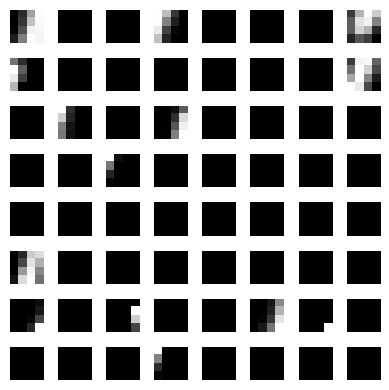

Group 1
Random Ordered


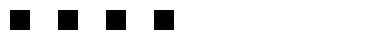

Ordered patches in a group


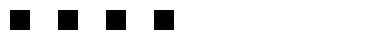

Group 2
Random Ordered


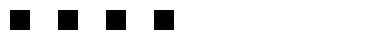

Ordered patches in a group


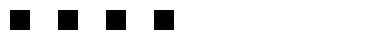

Group 3
Random Ordered


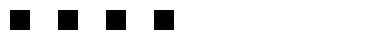

Ordered patches in a group


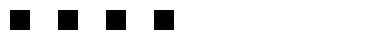

Group 4
Random Ordered


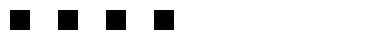

Ordered patches in a group


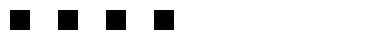

Group 5
Random Ordered


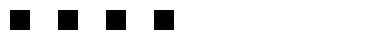

Ordered patches in a group


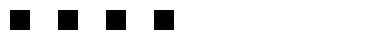

Group 6
Random Ordered


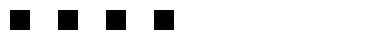

Ordered patches in a group


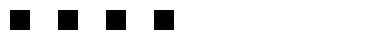

Group 7
Random Ordered


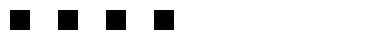

Ordered patches in a group


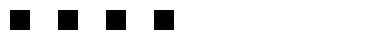

Group 8
Random Ordered


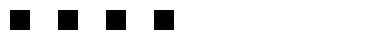

Ordered patches in a group


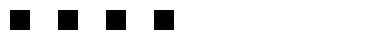

Group 9
Random Ordered


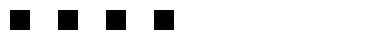

Ordered patches in a group


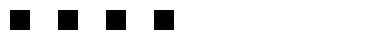

Group 10
Random Ordered


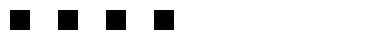

Ordered patches in a group


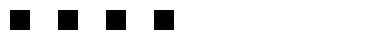

Group 11
Random Ordered


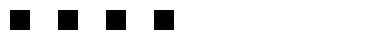

Ordered patches in a group


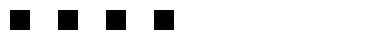

Group 12
Random Ordered


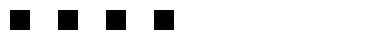

Ordered patches in a group


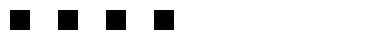

Group 13
Random Ordered


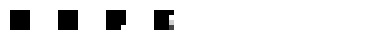

Ordered patches in a group


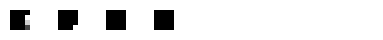

Group 14
Random Ordered


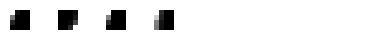

Ordered patches in a group


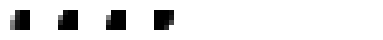

Group 15
Random Ordered


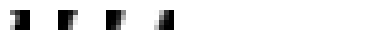

Ordered patches in a group


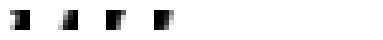

Group 16
Random Ordered


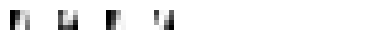

Ordered patches in a group


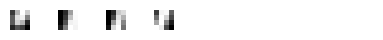

In [31]:
with torch.no_grad():    
    group_ordered_patches = []
    patch_order_list = []
    batch_size = inputs.size(0)
    plot_tensor_grid(random_pieces[0, :, 0, :])
    # random_group_pieces = model_grouping(random_pieces, training=False)
    patch_groups_indices = get_groups(random_pieces.view(-1, *random_pieces.shape[2:]), batch_size, num_groups=cfg.groups**2)
    for g in range(cfg.groups**2):
        print(f"Group {g+1}")
        group_indices = patch_groups_indices[:, g, :].reshape(-1)
        group_random_patches = random_pieces.view(-1, *random_pieces.shape[2:])[group_indices]
        group_random_patches = group_random_patches.view(batch_size, -1, *group_random_patches.shape[1:])
        # group_random_patches = random_group_pieces[:, g, :]
        
        print("Random Ordered")
        plot_tensor_grid(group_random_patches[0, :, 0, :])
        

        log_alpha_patch = model_patch(group_random_patches)
        patch_order_list.append(log_alpha_patch)
        gumbel_sinkhorn_mat = gumbel_sinkhorn_ops.gumbel_matching(log_alpha_patch, noise=False) 
        #gumbel_sinkhorn_mat = gumbel_sinkhorn_ops.gumbel_sinkhorn(log_alpha_patch, cfg.tau, cfg.n_sink_iter)
        group_ordered_pieces = gumbel_sinkhorn_ops.inverse_permutation_for_image(group_random_patches, gumbel_sinkhorn_mat)
        group_ordered_patches.append(group_ordered_pieces)

        print("Ordered patches in a group")
        plot_tensor_grid(group_ordered_pieces[0, :, 0, :])
    

torch.Size([1, 16, 4, 1, 4, 4])
torch.Size([1, 16, 1, 8, 8])
Random Group ordering


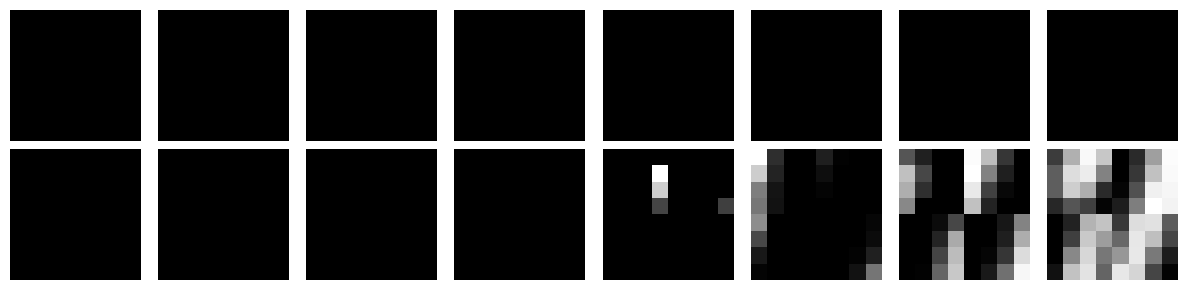

Ordered Groups


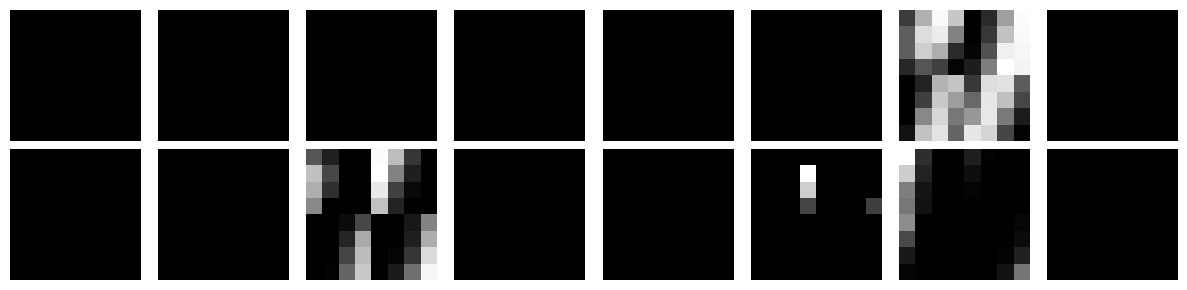

In [32]:
import copy
group_vectors_tensor = torch.stack(group_ordered_patches, dim=1)  # (B, G, D, 1)
print(group_vectors_tensor.shape)
random_groups = stack_patches_in_group(group_vectors_tensor)
print(random_groups.shape)

print("Random Group ordering")
plot_tensor_grid(random_groups[0, :, 0, :], size=1.5)

log_alpha_group = model_group(random_groups)
gumbel_sinkhorn_mat = gumbel_sinkhorn_ops.gumbel_matching(log_alpha_group, noise=False) 
#gumbel_sinkhorn_mat = gumbel_sinkhorn_ops.gumbel_sinkhorn(log_alpha_group, cfg.tau, cfg.n_sink_iter)
ordered_groups = gumbel_sinkhorn_ops.inverse_permutation_for_image(random_groups, gumbel_sinkhorn_mat)
tmp = copy.deepcopy(ordered_groups[0, 9, 0, :])
ordered_groups[0, 9, 0, :] = copy.deepcopy(ordered_groups[0, 10, 0, :])
ordered_groups[0, 10, 0, :] = copy.deepcopy(tmp)
print("Ordered Groups")
plot_tensor_grid(ordered_groups[0, :, 0, :], size=1.5)


torch.Size([1, 1, 32, 32])


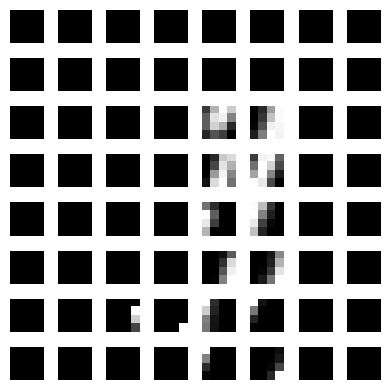

In [33]:
n = ordered_groups.shape[0]
full_imgs = reconstruct_image_from_groups(ordered_groups)
print(full_imgs.shape)

est_ordered_pieces, _, _ = batch_tch_divide_image(full_imgs, cfg.pieces)
plot_tensor_grid(est_ordered_pieces[0, :, 0, :])


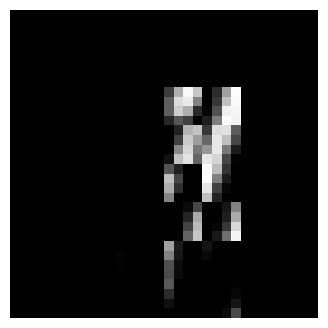

In [34]:
image = tensor_to_image(full_imgs[0, 0, :])
plt.figure(figsize=(4, 4))
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()